## Data Preparation and Cleaning

#### Import Packages

In [32]:
import geopandas as gpd
import pandas as pd
import numpy as np
from markupsafe import escape
from pycaret.datasets import get_data
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go
import imageio
import folium
import folium.plugins as plugins
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
import math
import shapely
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf 

In [33]:
df_final_pred= pd.read_csv('final_pred.csv',index_col=0)

In [34]:
df_table=df_final_pred.describe()

In [35]:
df_table.to_csv('to_table.csv')

In [36]:
df_table

,latitude,longitude,stars,prediction,difference
count,2324.000000,2324.000000,2324.000000,2324.000000,2324.000000
mean,39.975253,-75.153613,3.668460,3.670920,-0.002460
std,0.048413,0.052286,0.751035,0.556750,0.429541
min,39.874423,-75.363647,1.000000,1.654583,-2.475833
25%,39.948120,-75.176119,3.500000,3.363845,-0.030937
50%,39.954584,-75.160671,4.000000,3.713542,0.000347
75%,40.000352,-75.143967,4.000000,4.000000,0.052257
max,40.133248,-74.957990,5.000000,4.999432,2.056250


#### Read Yelp data

In [37]:
business_json_path = 'E:/Yelp/yelp_academic_dataset_business.json'
tip_json_path = 'E:/Yelp/yelp_academic_dataset_tip.json'
df_business= pd.read_json(business_json_path, lines=True)
df_tip= pd.read_json(tip_json_path, lines=True)

In [38]:
df_business.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."


In [39]:
df_tip.head(3)

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0


#### Check the information

In [40]:
df_business = df_business.dropna()

#### Filter the shops with 'open' status

In [41]:
df_business= df_business[df_business['is_open']==1]

## Exploratory Data Analaysis (EDA)

#### Distribution of the shops from Yelp datasets

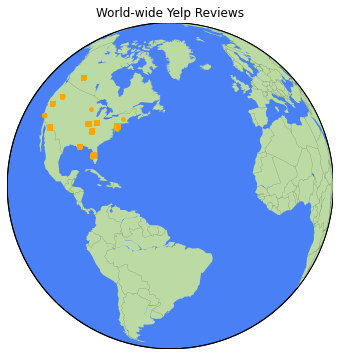

In [42]:
plt.figure(1, figsize=(15,6))
# use ortho projection for the globe type version
m1=Basemap(projection='ortho',lat_0=20,lon_0=-50)

# hex codes from google maps color pallete = http://www.color-hex.com/color-palette/9261
#add continents
m1.fillcontinents(color='#bbdaa4',lake_color='#4a80f5') 
# add the oceans
m1.drawmapboundary(fill_color='#4a80f5')                
# Draw the boundaries of the countires
m1.drawcountries(linewidth=0.1, color="black")

#Add the scatter points to indicate the locations of the businesses
mxy = m1(df_business["longitude"].tolist(), df_business["latitude"].tolist())
m1.scatter(mxy[0], mxy[1], s=3, c="orange", lw=3, alpha=1, zorder=5)
plt.title("World-wide Yelp Reviews")
plt.show()

In [43]:
drop_columns = ['hours','is_open']
df_b = df_business.drop(drop_columns, axis=1)

In [44]:
business_RV = df_b[df_b['categories'].str.contains(
              'RV Repair|RV Dealers|RV Rental|RV Parks|Campgrounds',
              case=False, na=False)]

In [45]:
df_state=df_b.assign(state=df_b.state).explode('state')

#### Choose the City for Analysis （Philadelphia）

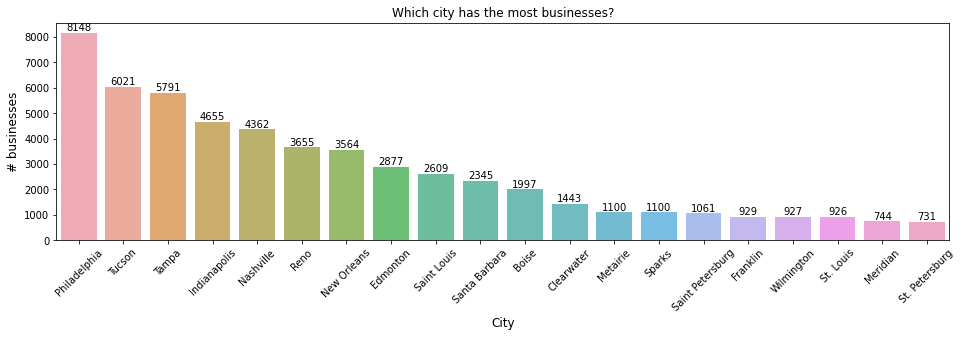

In [46]:
#Get the distribution of the ratings
x=df_business['city'].value_counts()
x=x.sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Which city has the most businesses?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [47]:
#get all ratings data
rating_data=df_business[['latitude','longitude','stars','review_count']]
# Creating a custom column popularity using stars*no_of_reviews
rating_data['popularity']=rating_data['stars']*rating_data['review_count']

<ipython-input-47-06125167a757>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<ipython-input-48-c1cb56ed7340>:39: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



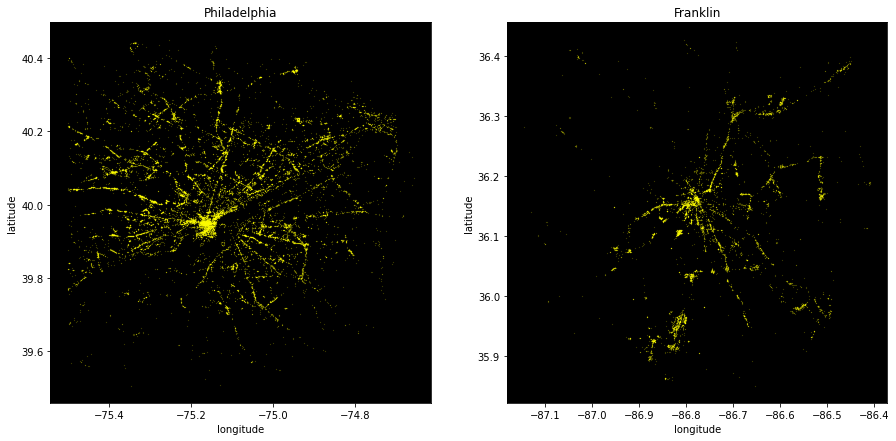

In [48]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

#a random point inside Philadelphia
lat = 40
lon = -75
#some adjustments to get the right pic
lon_min, lon_max = lon-0.5,lon+0.5
lat_min, lat_max = lat-0.5,lat+0.5
#subset for Philadelphia
ratings_data_pa=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]

#Facet scatter plot
ratings_data_pa.plot(kind='scatter', x='longitude', y='latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.set_title("Philadelphia")
ax1.set_facecolor('black')

#a random point inside Franklin
lat = 35.93
lon = -86.87
#some adjustments to get the right pic
lon_min, lon_max = lon-0.3,lon+0.5
lat_min, lat_max = lat-0.4,lat+0.5
#subset for pheonix
ratings_data_franklin=rating_data[(rating_data["longitude"]>lon_min) &\
                    (rating_data["longitude"]<lon_max) &\
                    (rating_data["latitude"]>lat_min) &\
                    (rating_data["latitude"]<lat_max)]
#plot Franklin
ratings_data_franklin.plot(kind='scatter', x='longitude', y='latitude',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.set_title("Franklin")
ax2.set_facecolor('black')
f.show()

Give the distributions of business of different cities. Philadelphia holds 10 times business of that in Franklin.
Around Franklin, there are lack of shops in suburban areas which is challenging for researches.

### Philadelphia Review heatmap Animation
to show the distribution of star ratings in this city

In [49]:
data=[]
#rearranging data to suit the format needed for folium
stars_list=list(rating_data['stars'].unique())
for star in stars_list:
    subset=ratings_data_pa[ratings_data_pa['stars']==star]
    data.append(subset[['latitude','longitude']].values.tolist())
#initialize at Philadelphia
lat = 40
lon = -75
zoom_start=11
print("     Philadelphia Review heatmap Animation ")

# basic map
m = folium.Map(location=[lat, lon], tiles="OpenStreetMap", zoom_start=zoom_start)
#inprovising the Heatmapwith time plugin to show variations across star ratings 
hm = plugins.HeatMapWithTime(data,max_opacity=0.3,auto_play=True,display_index=True,radius=7)
hm.add_to(m)
m

     Philadelphia Review heatmap Animation 


In [50]:
df_pa=df_b[df_b['city'].str.contains("Philadelphia")]

##### Pennsylvania Latitude and Longitude 
lon_min, lon_max = 74.43,80.43

lat_min, lat_max = 39.43,42

#### Philadelphia Location N39°57'，w75°10'
 Center City, Philadelphia 39.952,-75.164

## Quick Research on Urban areas and Suburban areas

In [51]:
df_pa=df_pa[df_pa['categories'].str.contains("Restaurants")]

In [52]:
top20_pa=df_pa.sort_values(by=[ 'stars'] ,ascending=False)[:20]
top20_pa.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
140560,trH0bWrq9kwLoLHbvlPKmw,Villekebabs and Platters,1722 Sansom St,Philadelphia,PA,19103,39.950574,-75.169746,5.0,21,"{'RestaurantsTableService': 'True', 'Restauran...","Restaurants, Mediterranean, Afghan, Halal"
41191,v92xgVl-BH_pQM486ea-9g,Greens and Grains,1700 Sansom St,Philadelphia,PA,19103,39.950639,-75.169199,5.0,14,"{'RestaurantsTakeOut': 'True', 'HappyHour': 'F...","Restaurants, Vegan"


In [53]:
bottom20_pa=df_pa.sort_values(by=[ 'stars'] ,ascending=True)[:20]
bottom20_pa.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories
40057,7j-s7IsivJLszx0s0w_QNw,Montego Grill,5222 Walnut St,Philadelphia,PA,19139,39.956840,-75.226335,1.0,5,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...","Restaurants, Bars, Trinidadian, Nightlife, Car..."
114511,DaQwz_kDKnv_kplacSUC7A,Burger King,171 W Chelton Ave,Philadelphia,PA,19144,40.032104,-75.179052,1.0,10,"{'RestaurantsReservations': 'False', 'Business...","Restaurants, Fast Food, Burgers"


In [54]:
bottom20_pa.to_csv('bottom20_pa.csv')

In [55]:
top20_pa.to_csv('top20_pa.csv')

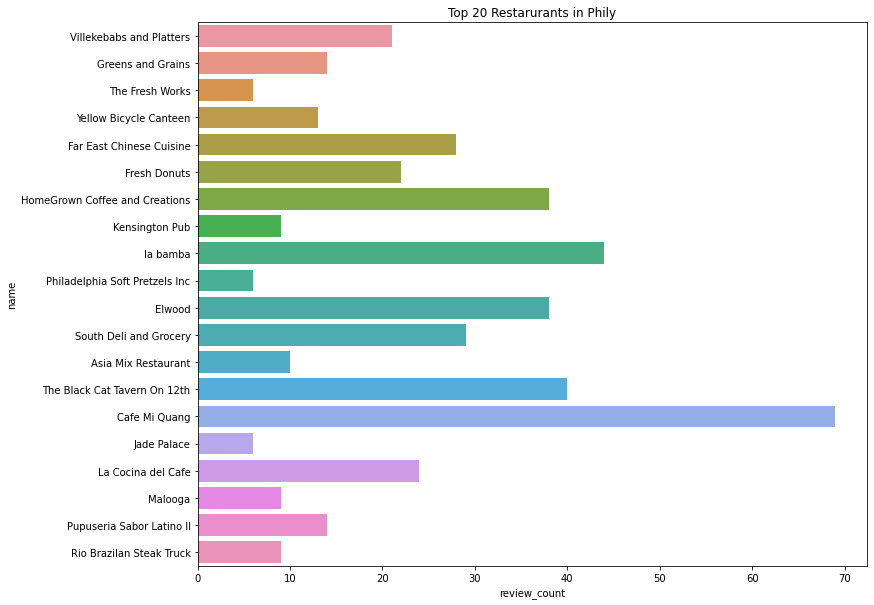

In [56]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = 'review_count', y = 'name', data=top20_pa, ax= ax);
#adding the text labels


plt.savefig('top20_restaurants_distance.png')
plt.title("Top 20 Restarurants in Phily")
plt.show()

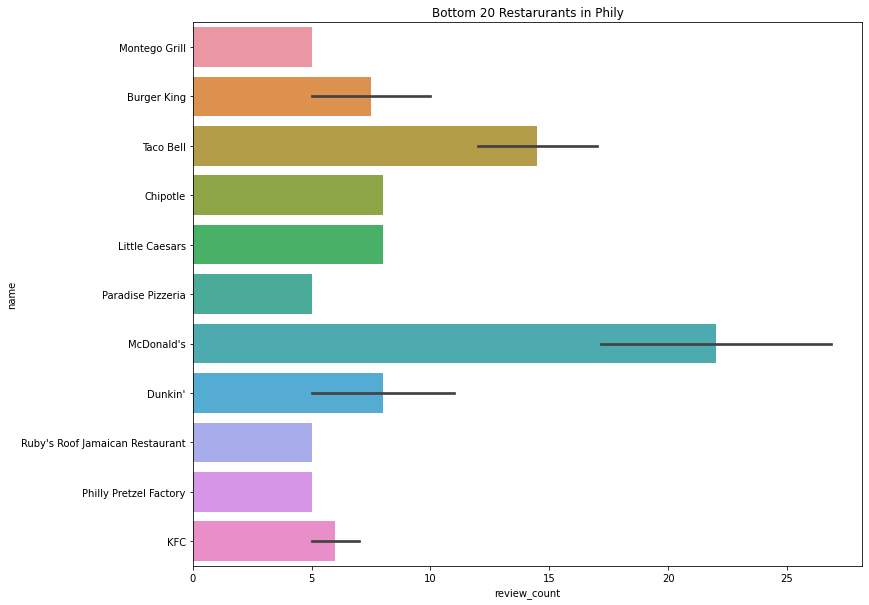

In [57]:
fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = 'review_count', y = 'name', data=bottom20_pa, ax= ax);
plt.savefig('bottom20_restaurants_distance.png')
plt.title("Bottom 20 Restarurants in Phily")
plt.show()

Populating the interactive namespace from numpy and matplotlib


E:\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning:

pylab import has clobbered these variables: ['Figure', 'pie', 'contour', 'bar', 'box', 'Annotation', 'f', 'scatter', 'table', 'histogram2d', 'histogram']
`%matplotlib` prevents importing * from pylab and numpy



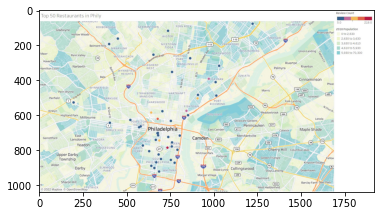

In [58]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_top= mpimg.imread('top50.jpg')
imgplot = plt.imshow(img_top)
plt.show()

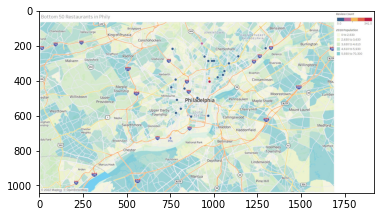

In [59]:
img_bottom= mpimg.imread('bottom50.jpg')
imgplot = plt.imshow(img_bottom)
plt.show()

##  Research Variables

### (i) Distance

#### K-Means Clustering 
Determing the number of clusters (K)


In [60]:
from sklearn.cluster import KMeans

In [61]:
import plotly_express as px

Philadelphia = df_pa[df_pa.city == 'Philadelphia']
coords = Philadelphia[['longitude','latitude']]

In [62]:
# Elbow method to determine the number of K in Kmeans Clustering
coords = Philadelphia[['longitude','latitude']]

distortions = []
K = range(1,25)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)

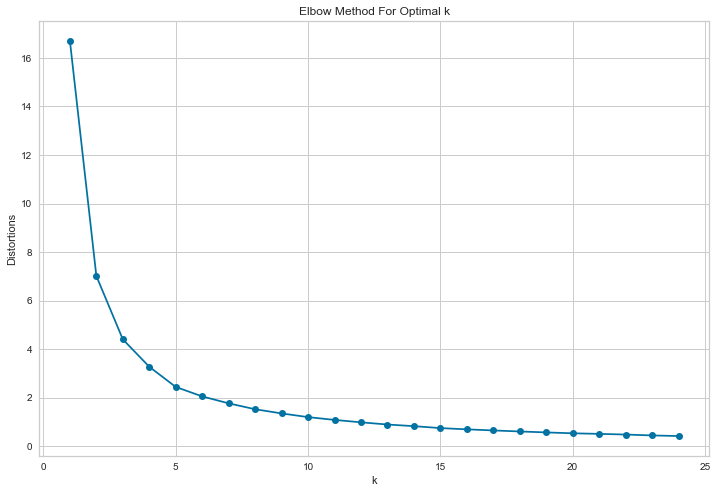

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.savefig('elbow.png')
plt.show()

In [65]:
from sklearn.metrics import silhouette_score

sil = []
kmax = 50

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [66]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 5", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 5  silhouette_score  0.49980600209571735


In [67]:
Philadelphia['cluster'] = kmeans.predict(Philadelphia[['longitude','latitude']])
Philadelphia.head()

<ipython-input-67-6abccfe980d7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,cluster
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",3
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese",3
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants",3
35,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,"{'OutdoorSeating': 'True', 'RestaurantsPriceRa...","Eatertainment, Arts & Entertainment, Brewpubs,...",3
82,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,PA,19104,39.954573,-75.194894,3.0,56,"{'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...","Restaurants, Automotive, Delis, Gas Stations, ...",0


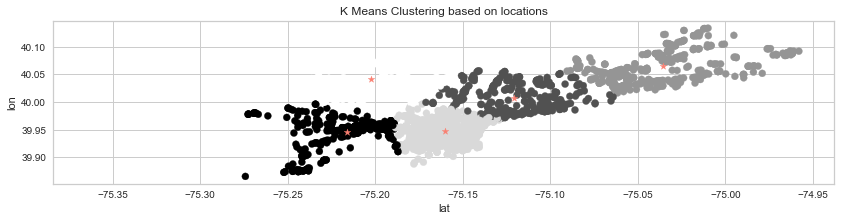

In [68]:
model = KMeans(n_clusters=5)
model.fit(coords)
all_predictions = model.predict(Philadelphia[['longitude','latitude']])
centroids = model.cluster_centers_

plt.figure(figsize=(14, 3))
plt.scatter(coords.iloc[:,0].values, coords.iloc[:,1].values, c=all_predictions)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='salmon')
plt.xlabel('lat')
plt.ylabel('lon')
plt.title('K Means Clustering based on locations')
plt.show()

 city_centre=[['city_centre',39.952,-75.164]]

In [69]:
city_centre=[['city_centre',39.952,-75.164]]

In [70]:
city_centre_po=pd.DataFrame(city_centre,columns=['Name','lat','log'])

In [71]:
po=gpd.GeoDataFrame(city_centre_po,geometry=gpd.points_from_xy(city_centre_po.lat,city_centre_po.log))

In [72]:
dfpa_geodata=gpd.GeoDataFrame(df_pa,geometry=gpd.points_from_xy(df_pa.latitude,df_pa.longitude))

In [73]:
distance=po.geometry.apply(lambda g: dfpa_geodata.distance(g))

In [74]:
distance_po = pd.DataFrame(distance.iloc[:,:].values, columns = list(distance.columns.values)[:] )

In [75]:
distance_po=distance_po.T

In [76]:
df_pa['Distance']=distance_po

### （ii）Scoring

In [77]:
df_merge_text = pd.merge(df_pa, df_tip, on = ['business_id'])

In [78]:
df_pa['attributes']

3         {'RestaurantsDelivery': 'False', 'OutdoorSeati...
15        {'RestaurantsReservations': 'True', 'Restauran...
19        {'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...
35        {'OutdoorSeating': 'True', 'RestaurantsPriceRa...
82        {'Alcohol': 'u'none'', 'RestaurantsGoodForGrou...
                                ...                        
150178    {'DogsAllowed': 'False', 'RestaurantsTakeOut':...
150210    {'WiFi': 'u'no'', 'BYOB': 'False', 'Restaurant...
150237    {'BikeParking': 'True', 'WheelchairAccessible'...
150306    {'NoiseLevel': 'u'average'', 'RestaurantsTakeO...
150336    {'WheelchairAccessible': 'False', 'Restaurants...
Name: attributes, Length: 3031, dtype: object

In [79]:
df_pa_a = df_pa.join(pd.DataFrame(df_pa['attributes'].to_dict()).T)

In [80]:
df_score=df_pa_a.drop(columns=['RestaurantsCounterService', 'DietaryRestrictions','AgesAllowed','Open24Hours','CoatCheck','BYOB','BestNights','GoodForDancing','Corkage','BYOBCorkage','AcceptsInsurance','DriveThru','BusinessAcceptsBitcoin','RestaurantsTableService','HappyHour'])

In [81]:
pd.set_option("display.max_columns", None)

In [82]:
df_score=df_score.drop(columns=['Smoking','NoiseLevel','BusinessParking','Alcohol','GoodForMeal','RestaurantsGoodForGroups','ByAppointmentOnly','HasTV','Ambience','Caters','RestaurantsAttire','RestaurantsPriceRange2'])

In [83]:
df_score=df_score.replace(np.NaN,0)

In [84]:
df_score.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,geometry,Distance,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsTakeOut,WiFi,RestaurantsReservations,GoodForKids,DogsAllowed,WheelchairAccessible,Music
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,False,False,False,True,True,u'free',0,0,0,0,0
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese",POINT (39.95395 -75.14323),0.020865,True,True,True,0,True,'free',True,False,False,True,0
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants",POINT (39.94322 -75.16257),0.008893,None,None,True,True,True,u'no',False,True,0,0,0


In [85]:
scores = {'True': 1, 'False': 0,'NaN':0,'None':0}
df_score=df_score.replace({'BusinessAcceptsCreditCards': scores, 'RestaurantsDelivery': scores,'GoodForKids':scores,'DogsAllowed':scores,'WheelchairAccessible':scores,
                           'OutdoorSeating': scores,'BikeParking': scores,'RestaurantsTakeOut': scores,'RestaurantsReservations': scores})

In [86]:
scores1={"'free'": 1, "u'free'":1,"u'no'":0,"'no'":0,'None':0,"'paid'":0.5,"u'paid'":0.5}
df_score=df_score.replace({'WiFi':scores1})

In [87]:
df_score=df_score.drop(columns=['postal_code','latitude','longitude','stars','review_count','attributes','categories','Music'])

In [88]:
df_score=pd.read_csv('score.csv')

In [89]:
df_score=df_score.drop(columns=['Unnamed: 0'])

### （iii）Sentiment (Polarity/Sujectivity)

In [90]:
from textblob import TextBlob

text = df_merge_text.text.iloc[0]
blob = TextBlob(text)
blob

# TextBlob("I am happy today. I feel sad today.")

blob.sentences
# [Sentence("I am happy today."), Sentence("I feel sad today.")]

[Sentence("Love their pastries and drinks!")]

In [91]:
def get_sentiment_eg(text):
    s = TextBlob(text)
    return s.sentiment
df_merge_text["sentiment_eg"] = df_merge_text.text.apply(get_sentiment_eg)
df_merge_text.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,geometry,Distance,user_id,text,date,compliment_count,sentiment_eg
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,WqeE5e5ROfaVEgkb9dAkiQ,Love their pastries and drinks!,2017-09-20 17:00:27,0,"(0.625, 0.6)"
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,dQDt0l5e9sre54eG7plUdA,Really good egg tart and bubble tea. Best we ...,2013-06-17 17:28:26,0,"(0.6, 0.6333333333333334)"
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,jmCga_DqsGhzSz0KnWSelQ,Was told they stopped making almond tarts... U...,2015-04-25 12:54:25,0,"(0.25, 0.65)"
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,lpnI226_ekGGvkx2Kd-biQ,After 6 pm the bread is on sale!,2016-05-11 20:09:04,0,"(0.0, 0.0)"
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,GfOYE8ChRLVT9izL6UXMNA,Best steamed pork bun in chinatown!,2017-12-13 17:48:19,0,"(1.0, 0.3)"


In [92]:
sentiment_series = df_merge_text['sentiment_eg'].tolist()

columns = ['polarity', 'subjectivity']

df_merge_text_sentiment = pd.DataFrame(sentiment_series, columns=columns, index=df_merge_text.index)

In [93]:
df_merge_text_sentiment.head()

,polarity,subjectivity
0,0.625,0.600000
1,0.600,0.633333
2,0.250,0.650000
3,0.000,0.000000
4,1.000,0.300000


In [94]:
df_merge_text['polarity'] = df_merge_text_sentiment['polarity']
df_merge_text['subjectivity'] = df_merge_text_sentiment['subjectivity']

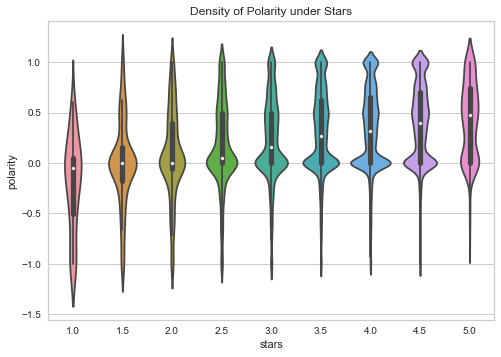

In [95]:
ax = sns.violinplot(x="stars", y="polarity", data=df_merge_text).set(title='Density of Polarity under Stars')

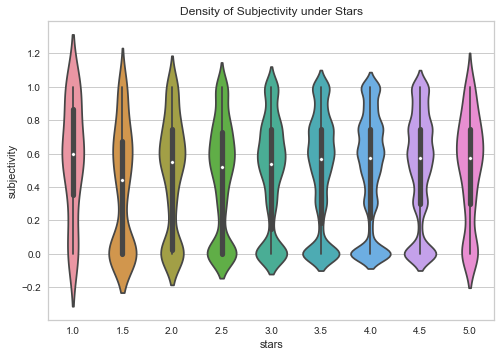

In [96]:
ax = sns.violinplot(x="stars", y="subjectivity", data=df_merge_text).set(title='Density of Subjectivity under Stars')

In [97]:
df_merge_text.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'attributes',
       'categories', 'geometry', 'Distance', 'user_id', 'text', 'date',
       'compliment_count', 'sentiment_eg', 'polarity', 'subjectivity'],
      dtype='object')

### （iv）Review Count

In [98]:
df_merge_text.review_count.describe()

count    60938.000000
mean       713.124126
std        956.179649
min          5.000000
25%        162.000000
50%        383.000000
75%        796.000000
max       5721.000000
Name: review_count, dtype: float64

### (v) Text Length

In [99]:
df_merge_text['text_length']=df_merge_text['text'].str.len()

In [100]:
df_merge_text

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,geometry,Distance,user_id,text,date,compliment_count,sentiment_eg,polarity,subjectivity,text_length
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,WqeE5e5ROfaVEgkb9dAkiQ,Love their pastries and drinks!,2017-09-20 17:00:27,0,"(0.625, 0.6)",0.625,0.600000,31
1,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,dQDt0l5e9sre54eG7plUdA,Really good egg tart and bubble tea. Best we ...,2013-06-17 17:28:26,0,"(0.6, 0.6333333333333334)",0.600,0.633333,74
2,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,jmCga_DqsGhzSz0KnWSelQ,Was told they stopped making almond tarts... U...,2015-04-25 12:54:25,0,"(0.25, 0.65)",0.250,0.650000,133
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,lpnI226_ekGGvkx2Kd-biQ,After 6 pm the bread is on sale!,2016-05-11 20:09:04,0,"(0.0, 0.0)",0.000,0.000000,32
4,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...",POINT (39.95551 -75.15556),0.009135,GfOYE8ChRLVT9izL6UXMNA,Best steamed pork bun in chinatown!,2017-12-13 17:48:19,0,"(1.0, 0.3)",1.000,0.300000,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60933,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,Philadelphia,PA,19128,40.032483,-75.214430,3.0,55,"{'NoiseLevel': 'u'average'', 'RestaurantsTakeO...","Restaurants, Specialty Food, Food, Sandwiches,...",POINT (40.03248 -75.21443),0.094977,5J_LxGmdBEPp9La0jXjPng,"Old Italian. The hoagie, not me.",2011-05-26 18:16:12,0,"(0.05, 0.1)",0.050,0.100000,32
60934,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,"{'WheelchairAccessible': 'False', 'Restaurants...","Restaurants, Mexican",POINT (39.93598 -75.15866),0.016883,sqKWVIMXm1RGAlvVQYaiHw,Al Pastor Tacos,2017-11-18 19:33:07,0,"(0.0, 0.0)",0.000,0.000000,15
60935,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,"{'WheelchairAccessible': 'False', 'Restaurants...","Restaurants, Mexican",POINT (39.93598 -75.15866),0.016883,mdd6ilFfRrC8f1mpScGtZw,Very nice food fun,2018-03-23 00:37:38,0,"(0.54, 0.6)",0.540,0.600000,18
60936,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,"{'WheelchairAccessible': 'False', 'Restaurants...","Restaurants, Mexican",POINT (39.93598 -75.15866),0.016883,s6CilHlWWxqbu3Mr2r8MXg,Service and food were wonderful.,2018-10-21 23:56:27,0,"(1.0, 1.0)",1.000,1.000000,32


In [101]:
df_merge_final=pd.merge(df_merge_text,df_score,on = ['business_id'])
df_merge_final=df_merge_final[['business_id','name_x','latitude','longitude','stars','review_count','Distance','text_length','compliment_count','polarity','subjectivity','Scores','categories']]

In [102]:
df_analysis=df_merge_final.drop(columns=['name_x'])

In [103]:
df_analysis=df_analysis.drop(columns=['categories','latitude','longitude','business_id'])

In [104]:
df_analysis.head(3)

,stars,review_count,Distance,text_length,compliment_count,polarity,subjectivity,Scores
0,4.0,80,0.009135,31,0,0.625,0.600000,3.0
1,4.0,80,0.009135,74,0,0.600,0.633333,3.0
2,4.0,80,0.009135,133,0,0.250,0.650000,3.0


In [106]:
df_analysis_x=df_analysis.drop(columns=['stars'])

## Variables Analysis

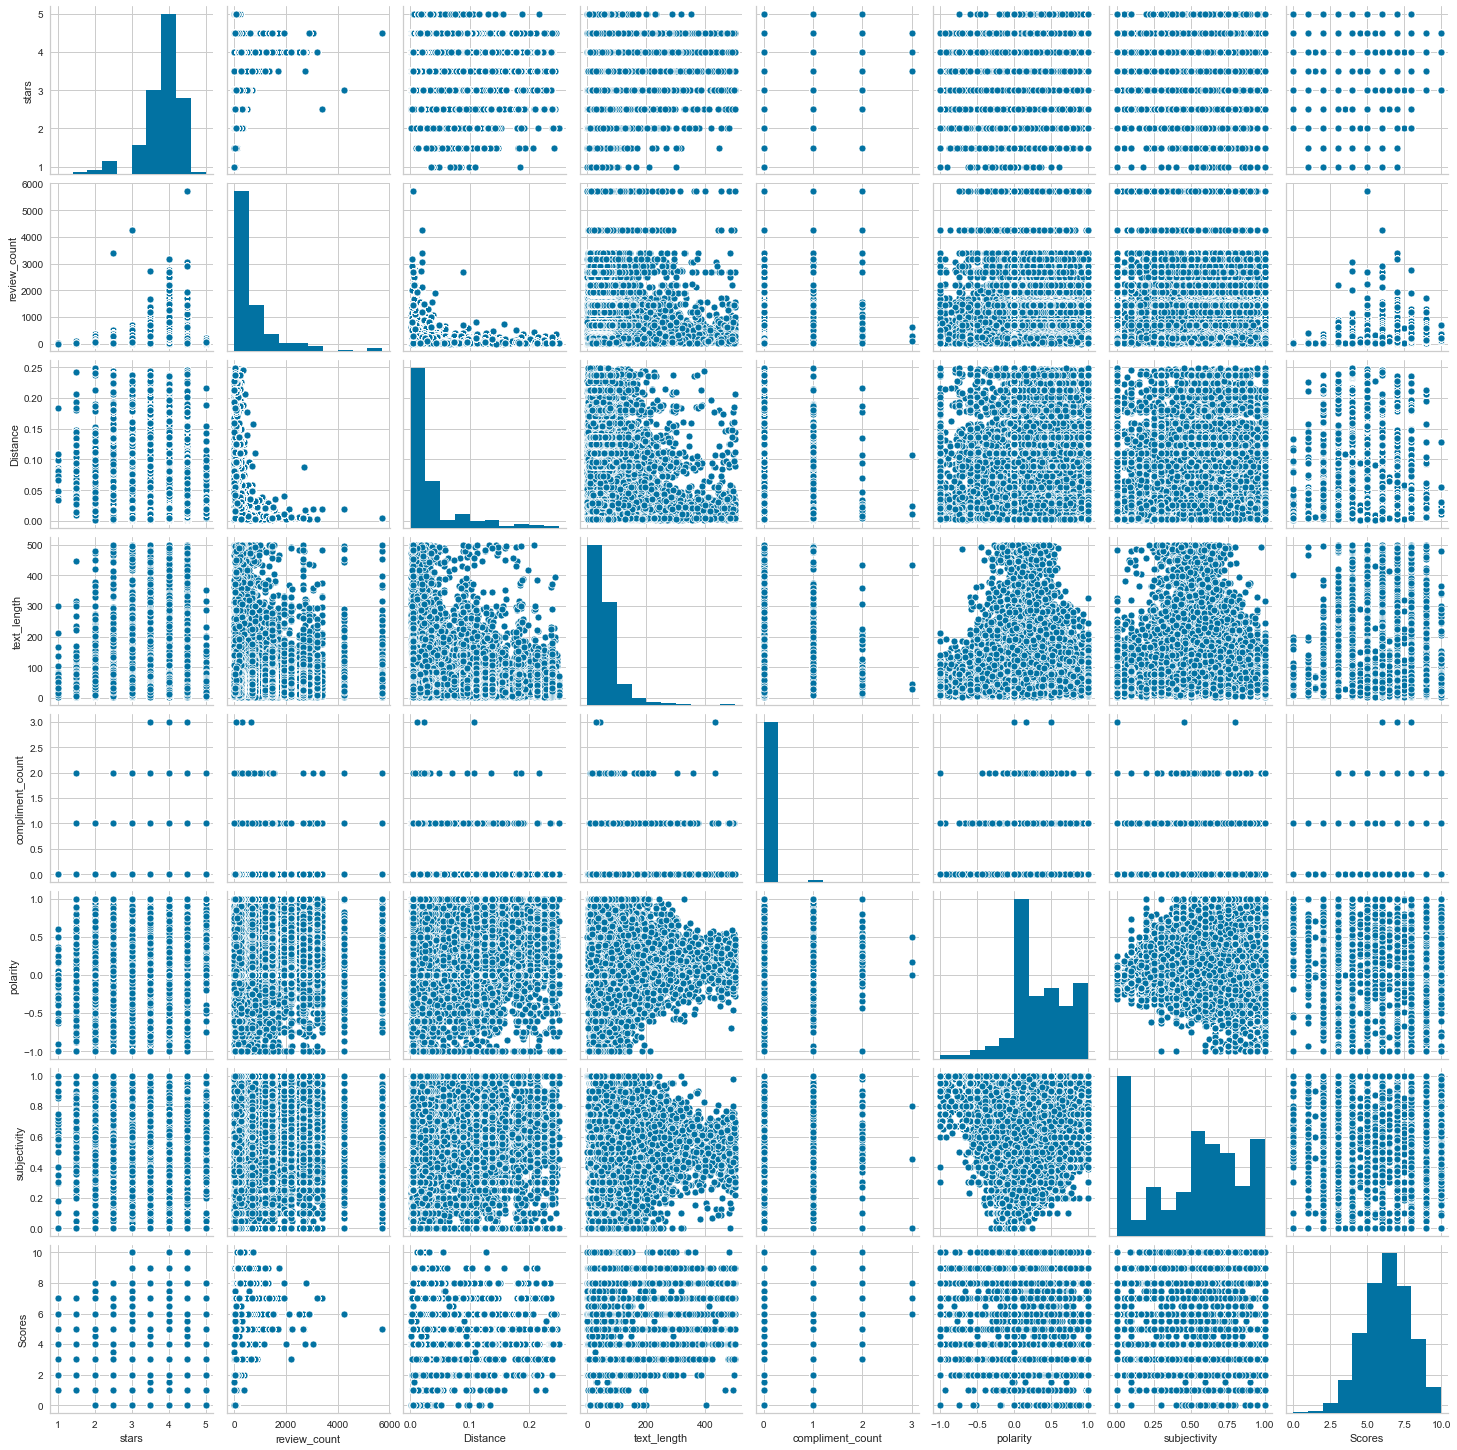

In [107]:
sns_plot=sns.pairplot(df_analysis)
plt.savefig('output.png')

check variables by plots

3.2 Cosine Similarity vs. Pearson Similarity Cosine similarity and Pearson correlation coefficient are two common similarity measures of user-item similarity. Cosine similarity of two vectors is defined as below: 𝑐𝑜𝑠𝑖𝑛𝑒 𝑠𝑖𝑚𝑖𝑙𝑎𝑟𝑖𝑡𝑦 = cos 𝜃 = 𝐀 ∙ 𝐁 ||𝐀||||𝐁|| = ∑ 𝐴𝑖𝐵𝑖 𝑛 𝑖=1 √∑ 𝐴𝑖 𝑛 2 𝑖=1 √∑ 𝐵𝑖 𝑛 2 𝑖=1 Pearson correlation coefficient is basically the cosine similarity of the centered vectors: 𝑝𝑒𝑎𝑟𝑠𝑜𝑛 𝑐𝑜𝑟𝑟𝑒𝑙𝑎𝑡𝑖𝑜𝑛 𝑐𝑜𝑒𝑓𝑓𝑖𝑐𝑖𝑒𝑛𝑡 = ∑ (𝐴𝑖 − 𝐴̅)(𝐵𝑖 − 𝐵̅) 𝑛 𝑖=1 √(∑ (𝐴𝑖 − 𝐴̅) 2 𝑛 𝑖=1 )(∑ (𝐵𝑖 − 𝐵̅) 2 𝑛 𝑖=1

Text(0.5, 1.0, 'Correlation Matrix on Independent Variables')

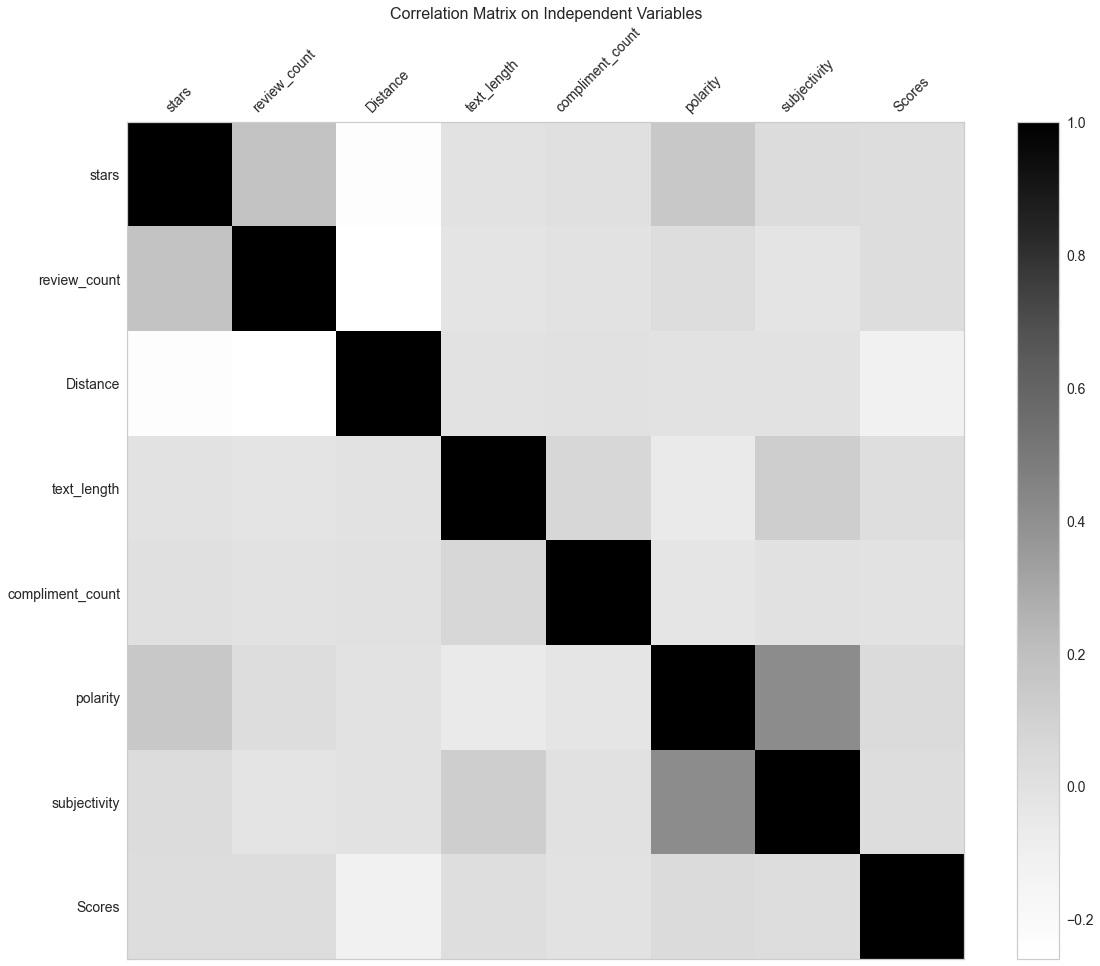

In [108]:
df = df_analysis
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix on Independent Variables', fontsize=16)

TypeError: text() missing 1 required positional argument: 's'

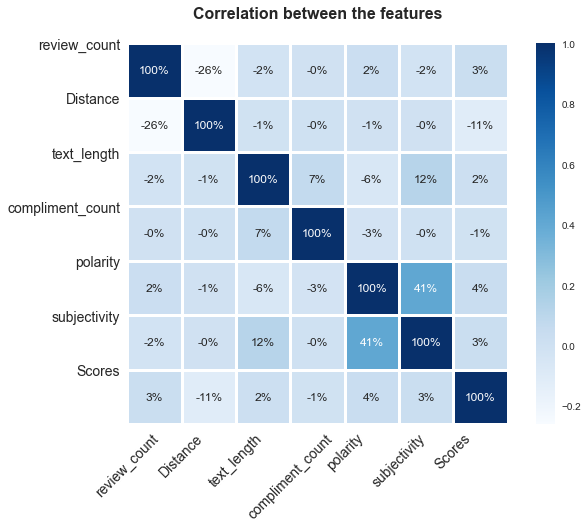

In [110]:
fig=plt.figure(figsize=(10,7))
axis=sns.heatmap(df_analysis_x.corr(), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%")
plt.xticks(range(df_analysis_x.shape[1]), df_analysis_x.columns, fontsize=14, rotation=45)
plt.yticks(range(df_analysis_x.shape[1]), df_analysis_x.columns, fontsize=14)
axis.set_title('Correlation between the features', fontsize=16, weight='bold', y=1.05);
plt.savefig('output_matrix.png')

fig.text(0.5, 0.0, ha = 'center', fontsize = 14, weight = 'bold');

# Checking the distribution of the variable:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,6))
sns.distplot(df_analysis.stars, bins=25)
plt.xlabel('Stars')
plt.title('Distribuition of star rating');

In [ ]:
# Descriptive statistics for target:
df_analysis['stars'].describe()

In [ ]:
print(f'Kurtosis: {df_analysis.stars.kurt()}')
print(f'Asymmetry: {df_analysis.stars.skew()}')

In [ ]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [ ]:
df_analysis_x = drop_column_using_vif_(df_analysis_x)

In [ ]:
df_analysis_x

In [ ]:
X = df_analysis.drop(['stars','business_id'], axis=1)
y = df_analysis['stars']

Kurtosis is used to identify outliers in the distribution. Here, its value is > 3, which means that the distribution tails tend to be lighter than in normal distribution or, the lack of outliers.

The positive asymmetry means that we have a slightly tail on the right side of the distribution. The data is moderately skewed as our asymmetry value is between 0.5 and 1.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
import pycaret
from pycaret.regression import *

In [ ]:
X_train.shape, X_test.shape,y_train.shape,y_test.shape

In [ ]:
df_analysis.describe()

In [ ]:
#df_analysis=df_analysis.drop(columns=['compliment_count'])

In [ ]:
pipeline = setup(data = df_analysis, target = 'stars', numeric_features = ['compliment_count'])

In [ ]:
evaluate_model

In [ ]:
data = {'Linear Regression':0.0891, 'Decision Tree Regressor':0.7549, 'Random Forest Regressor':0.8678,
        'Gradient Boosting Regressor':0.3414}
Models = list(data.keys())
R_square = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(Models, R_square, color ='maroon',
        width = 0.4)

plt.xlabel("Model Selected")
plt.ylabel("Value of R_Square")
plt.title("model selection via R^2")
plt.show()


In [ ]:
best=compare_models()

In [ ]:
fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="blue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
plt.title('title')
plt.xlabel('x')
plt.ylabel('y')      
#plt.show()
plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

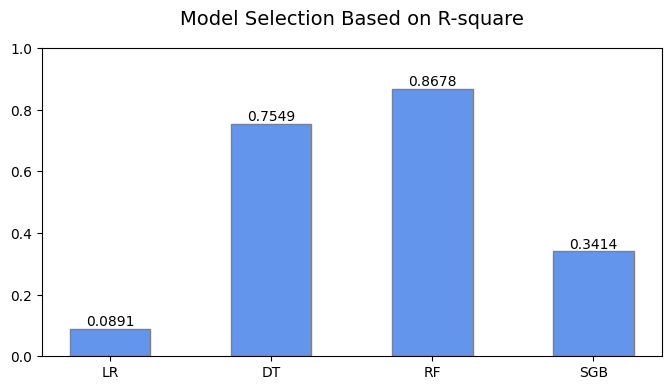

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,4), dpi=100)
y_data = [0.0891, 0.7549,0.8678,0.3414]
x_data = ('LR', 'DT', 'RF', 'SGB')

bar = plt.bar(x_data, y_data, 0.5,color='cornflowerblue',edgecolor='grey')

ax.set_title('Model Selection Based on R-square',fontsize=14,y=1.05)

ax.set_ylabel("",fontsize = 12,color = 'black',alpha = 0.7,rotation=360)
ax.set_ylim(0,1)
for a,b in zip(x_data, y_data):
    plt.text(a,b,
             b,
             ha='center', 
             va='bottom',
            )


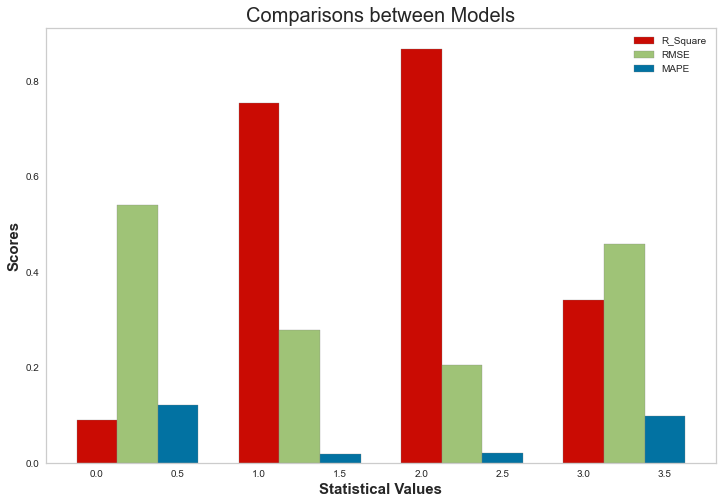

In [111]:
barWidth = 0.25
     
        
fig = plt.subplots(figsize =(12, 8))
# set height of bar
R_Square = [0.0891, 0.7549,0.8678,0.3414]
RMSE = [0.5392, 0.2791, 0.2053,0.4585]
MAPE = [0.1213, 0.0188, 0.0207,0.0980]
 

    
# Set position of bar on X axis
br1 = np.arange(len(R_Square))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, R_Square, color ='r', width = barWidth,
        edgecolor ='grey', label ='R_Square')
plt.bar(br2, RMSE, color ='g', width = barWidth,
        edgecolor ='grey', label ='RMSE')
plt.bar(br3, MAPE, color ='b', width = barWidth,
        edgecolor ='grey', label ='MAPE')
 
# Adding Xticks
plt.xlabel('Statistical Values', fontweight ='bold', fontsize = 15)
plt.ylabel('Scores', fontweight ='bold', fontsize = 15)
plt.title("Comparisons between Models",fontsize=20)
plt.savefig('output_compare.png')
plt.legend()

plt.show()

In [ ]:
model = create_model('rf', fold=5, round=2)

In [ ]:
# Checking score after cross-validation:
predict_model(model)

In [ ]:
finalize_model(model)

In [ ]:
# Feature Importance
plot_model(model, plot='feature')

In [ ]:
predictions = predict_model(model, data=df_analysis, round=2)
predictions

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
predictions = rf_model.predict(X_test)

result = X_test
result['price'] = y_test
result['prediction'] = predictions.tolist()
result.head()

In [ ]:
estimators = np.arange(10, 250, 10) # 10 to 250 increased with 10
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_train, y_train))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [ ]:
estimators = np.arange(10, 250, 10) # 10 to 250 increased with 10
scores = []
for n in estimators:
    model.set_params(n_estimators=n)
    model.fit(X_train, y_train)
    scores.append(model.score(X_train, y_train))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection

# values of n_estimators
parameters = {'n_estimators':[50,150,180,200,240]}
rf = RandomForestRegressor()

# cv=5 by default, which means 5-fold cross-validation
clf = model_selection.GridSearchCV(rf, parameters)

clf.fit(X_train, y_train)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=50, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=240, max_features="auto", random_state=44,)
rf_model.fit(X_train, y_train)

In [ ]:
#After tuning hyperparameters
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)

# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))
print('R-squared scores:', round(r2, 4))

In [ ]:
rf_model.feature_importances_

In [ ]:
importances=rf_model.feature_importances_
columns=X.columns
i=0

while i<len(columns):
    print(f"The importance of feature '{columns[i]}' is {round(importances[i]*100,2)}%.")
    i+=1

In [ ]:
df_final=predict_model(rf_model)

In [ ]:
df_final['difference']=df_final.apply(lambda row: row.stars - row.Label, axis=1)

In [ ]:
df_final.head(100)

In [ ]:
df_final.describe()

In [ ]:
df_final_change=df_final[(df_final['difference'] >0) | (df_final['difference'] < 0)]

In [ ]:
df_final_change

In [ ]:
df_final_change.to_csv('df_final_change.csv')

In [ ]:
df_final_change.describe()

In [ ]:
df_business_stars = df_pa[['review_count','latitude','longitude','stars','Distance']].copy()

In [ ]:
df_leftmerge = df_final_change.merge(df_business_stars, how='left', left_on=['Distance'], right_on=['Distance'])

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

importance_x = ['review_count','distance','text_length','compliment_count','polarity','subjectivity','scores']
importance_y = [41.2,40.1,3.35,0.09,3.81,2,9.44]

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(importance_y))  # the x locations for the groups
ax.barh(ind, importance_y, width, color='#7eb54e')
ax.set_yticks(ind+width/2)
for bars in ax.containers:
    ax.bar_label(bars)

ax.set_yticklabels(importance_x, minor=False)
plt.title('Feature Importance Percentage')
plt.xlabel('Percentage of Importance')
plt.ylabel('importance')      
#plt.show()
plt.show()
plt.savefig(os.path.join('test.png'), dpi=300, format='png', bbox_inches='tight') # use format='svg' or 'pdf' for vectorial pictures

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=240, max_features="auto", random_state=44)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [ ]:
X_test['prediction']=y_pred

In [ ]:
X_test

In [ ]:
df_pa

In [ ]:
df_merge_pred=X_test.merge(df_pa, how='right', left_on=['Distance'], right_on=['Distance'])

In [ ]:
df_merge_pred

In [ ]:
df_get=df_merge_pred.groupby(['latitude', 'longitude', 'stars','name'])['prediction'].mean().reset_index()

In [ ]:
df_get=df_get.dropna()

In [ ]:
df_get['difference']=df_get.apply(lambda row: row.stars - row.prediction, axis=1)

In [ ]:
df_get.to_csv('final_pred.csv')

In [ ]:
df_get

In [ ]:
df_get.describe()

In [ ]:
plt.scatter(X_test['review_count'].values, y_test, color = 'red')
plt.scatter(X_test['review_count'].values, y_pred, color = 'green')
plt.title('Random Forest Regression')
plt.xlabel('review_count')
plt.ylabel('Stars')
plt.show() 